# Multi-task Age-Gender prediction based on UTKFaces dataset <a class="jp-toc-ignore"></a>

This notebook provides the analysis and prediction for age and gender of UTKFaces dataset from https://www.kaggle.com/jangedoo/utkface-new.

The version that was used was preprocessed by provider to 200x200. This data was stored in personal drive and used through the analysis and modeling.
Each image path is labeled: age_gender_ethnicity_path. Age is an integer from 0 to 116, indicating the age. Gender is either 0 (male) or 1 (female). Race is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).

The objective for this notebook was to build and train a single model which would perform regression on ages and classification on genders within single pass with possibly lowest MSE for age and highiest accuracy for gender. Then expaining the model with possible bias.

EDA:

* check of sizing, color channels and extensions of pictures
* removing pictures with incomplete labels
* analysing distributions

Modeling:

For modeling part I used a couple of approaches with iterative adjustemnt of hyperparameters.
* stratified split of train, validation and test set for each age/gender/ethicity group
* adding layers to head
* undersampling up to 250 samples in each age/gender/ethnicity group
* experimenting with different batch sizes
* augmentation of minority groups
* experimenting with ResNet18 and ResNet34

In the notebook I left the best performing experiments.

In [ ]:
!pip install --quiet fastai pytorch-lightning lime scikit-image iterative-stratification torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 18.3 MB/s eta 0:00:00


In [ ]:
from google.colab import files, drive
from typing import Tuple, List, Any
from itertools import chain
import pandas as pd
import numpy as np
import os
import multiprocessing
from itertools import chain
from typing import List, Tuple, Any, Dict
import shutil
import random
from math import log
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter
import matplotlib.image as mpimg
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import transforms, models
from torchvision.transforms import AutoAugmentPolicy, AutoAugment
from torchvision.models import resnet34, ResNet34_Weights
from lime import lime_image
from skimage.segmentation import mark_boundaries
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import indexable, _safe_indexing
from sklearn.utils.validation import _num_samples
from sklearn.model_selection._split import _validate_shuffle_split
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from fastai import *
from fastai.vision.all import *
from fastai.vision.data import ImageDataLoaders
import warnings
warnings.filterwarnings("ignore")
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# ******************** EDA ********************
def dimension(path: str) -> Tuple:
    """Gets the dimensions of the picture
    from the picture path.
    Args:
        path (str): the path
    Returns:
        width, height (Tuple)"""

    image = Image.open( URL + "UTKFace/" + path)
    width, height = image.size
    return width, height


def add_legend(x: float, y: float) -> None:
    """
    Add a legend to the current matplotlib plot at the specified position.
    Args:
        x (float): x-coordinate of the legend's anchor point
        y (float): y-coordinate of the legend's anchor point.
    Returns:
        None
    """
    patches = [
        Patch(color="#05B2DC", label="Male"),
        Patch(color="#F64740", label="Female")
    ]

    leg = plt.legend(
        handles=patches,
        bbox_to_anchor=(x, y), loc='center',
        ncol=2, fontsize=10,
        handlelength=1, handleheight=0.4,
    )


def plot_age_gender_dist(df: pd.DataFrame, ax: plt.Axes) -> plt.Axes:
    """
    Plot the age and gender distribution using a horizontal bar chart.
    Args:
        df (pd.DataFrame): DataFrame containing 'gender' and 'age_group' columns.
        ax (plt.Axes): Matplotlib Axes object to plot on.
    Returns:
        plt.Axes: Matplotlib Axes object with the plotted distribution.
    """
    df_m = df.loc[df['gender'] == 0].groupby("age_group")['age'].count().reset_index()
    df_f = df.loc[df['gender'] == 1].groupby("age_group")['age'].count().reset_index()
    sns.barplot(y=df_m["age_group"], x=df_m["age"] * -1, orient="h", color="#05B2DC", ax=ax)
    sns.barplot(y=df_f["age_group"], x=df_f["age"], orient="h", color="#F64740", ax=ax)
    ax.axvline(x=250, color='black', linestyle='--', linewidth=0.5)
    ax.axvline(x=-250, color='gray', linestyle='-', linewidth=0.5)
    return ax


def format_ticks(x: Any, pos: int) -> str:
    """Format ticks as absolute integer values."""
    return abs(x).astype(int)

def age_gender_plot(df: pd.DataFrame, race_labels: List[str]) -> None:
    """
    Create a distribution plot for ages and genders for each ethnic group.
    Args:
        df (pd.DataFrame): DataFrame containing data with columns
                           'race', 'age', and 'gender'.
        race_labels (List[str]): List of ethnic group labels.
    Returns:
        None
    """
    fig, axs = plt.subplots(1, 5, figsize=(16, 5), sharey=True)
    fig.suptitle("Distribution of ages and genders for each ethnic group")

    for i, race in enumerate(race_labels):
        plot_age_gender_dist(df.loc[df['race'] == i], axs[i])
        axs[i].set_ylabel("")
        axs[i].set_title(race, y=1.06, fontsize=10)
        axs[i].set_xlabel("")
        axs[i].set_xlim(-800, 800)
        axs[i].xaxis.set_major_formatter(FuncFormatter(format_ticks))

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5, top=0.75)
    add_legend(x=-1.7, y=1.2)



# ******************** SPLITING DATA ********************
def multilabel_train_test_split(
    *arrays: Any,
    test_size: float = None,
    train_size: float = None,
    random_state: int = 123,
    shuffle: bool = True,
    stratify: List = None,
) -> List:
    """
    Train test split for multilabel classification. Uses the algorithm from:
    'Sechidis K., Tsoumakas G., Vlahavas I. (2011)
    On the Stratification of Multi-Label Data'.
    Args:
        *arrays (Any): any number of arrays to be splitted
        test_size (float): fration of test split
        train_size (float): fraction of data for train set
        random_state (int): random seed
        shuffle (bool): whether to shuffle data before split
        stratify (List): list representing stratification
    Returns:
        Tuple: a tuple of split arrays
    """

    if stratify is None:
        return train_test_split(
            *arrays,
            test_size=test_size,
            train_size=train_size,
            random_state=random_state,
            stratify=None,
            shuffle=shuffle,
        )

    assert shuffle, "Stratified train/test split is not implemented for shuffle"

    len(arrays)
    arrays = indexable(*arrays)
    n_samples = _num_samples(arrays[0])
    n_train, n_test = _validate_shuffle_split(
        n_samples, test_size, train_size, default_test_size=0.25
    )
    cv = MultilabelStratifiedShuffleSplit(
        test_size=n_test, train_size=n_train, random_state=random_state
    )
    train, test = next(cv.split(X=arrays[0], y=stratify))

    return list(
        chain.from_iterable(
            (_safe_indexing(a, train), _safe_indexing(a, test)) for a in arrays
        )
    )



def augment_images(files_list: List, total_nr: int=250) -> None:
    """
    Copies images from drive to runtime /content/aug_data/ folder and
    augments images to given number.
    Args:
        files_list (List): List of path files to be copied and augmented.
        total_nr (int): Number of desired images in total.
    Return:
        None
    """
    augmentation = transforms.Compose(
        [
            AutoAugment(policy=AutoAugmentPolicy.IMAGENET),
        ]
    )
    if total_nr >=len(files_list):
        num_augmentations = total_nr - len(files_list)
        # Copy images from source to output directory
        [shutil.copy(URL+ "UTKFace/" + path, '/content/aug_data/'+ path) for path in files_list]
        for i in range(num_augmentations):
            random_file = random.choice(files_list)
            random_path = os.path.join(URL+'UTKFace', random_file)
            input_image = Image.open(random_path)
            augmented_image = augmentation(input_image)
            new = f"{os.path.splitext(random_file)[0]}_aug_{i+1}{os.path.splitext(random_file)[1]}"
            augmented_image.save(os.path.join('/content/aug_data/', new))


# ******************** MODELING ********************

def split_layers(m: nn.Module) -> list:
    """
    Split the layers of a model into four groups for differential learning rates.
    Args:
        m (nn.Module): The input model.
    Returns:
        List of layer groups.
    """
    return L(m.encoder[:6], m.encoder[6:7], m.encoder[7:], m.fc).map(params)


# ******************** MAKING PREDICTIONS ********************
def get_predictions(model: torch.nn.Module,
                    dataloader: torch.utils.data.DataLoader,
                    device: torch.device) -> Tuple[List[List[float]],
                                                   List[List[float]],
                                                   List[List[int]],
                                                   List[List[int]],
                                                   List[List[str]]]:
    """
    Get predictions from a model on a given dataloader.
    Args:
        model (torch.nn.Module): The trained model.
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset.
        device (torch.device): Device to which the model should be moved.
    Returns:
        Tuple containing lists of predictions for age, gender, targets for age,
        targets for gender, and image paths.
    """
    model = model.eval().to(device)
    preds_age = []
    preds_gender = []
    targets_age = []
    targets_gender = []
    paths = []
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            output = model(batch[0].view(-1, 3, 224, 224).to(device))
            preds_age.append(output[0].flatten().tolist())
            preds_gender.append(torch.sigmoid(output[1]).cpu().flatten().tolist())
            targets_age.append(batch[1][0].tolist())
            targets_gender.append(batch[1][1].tolist())
            paths.append(list(batch[1][2]))
    return preds_age, preds_gender, targets_age, targets_gender, paths


def gender_proba(x: pd.Series) -> float:
    """
    Calculate the probability of the predicted gender.
    Args:
        x (pd.Series): DataFrame row containing 'gender' and 'pred_gender' columns.
    Returns:
        Probability of the predicted gender.
    """
    if x['gender'] == 0:
        return 1 - x['pred_gender']
    else:
        return x['pred_gender']


def prediction_df_builder(preds_age: List[List[float]],
                          preds_gender: List[List[float]],
                          targets_age: List[List[int]],
                          targets_gender: List[List[int]],
                          paths: List[List[str]]) -> pd.DataFrame:
    """
    Build a DataFrame from prediction results.
    Args:
        preds_age (List[List[float]]): List of lists containing predicted ages.
        preds_gender (List[List[float]]): List of lists containing predicted gender probabilities.
        targets_age (List[List[int]]): List of lists containing true ages.
        targets_gender (List[List[int]]): List of lists containing true gender labels.
        paths (List[List[str]]): List of lists containing image paths.
    Returns:
        DataFrame containing predicted age, predicted gender, true age,
        true gender, image paths, MSE,
        acc defined as absolute value of difference between sigmoid probability and true gender
        and probability for given gender class.
    """
    flat_preds_age = list(chain(*preds_age))
    flat_preds_gender = list(chain(*preds_gender))
    flat_targets_age = list(chain(*targets_age))
    flat_targets_gender = list(chain(*targets_gender))
    flat_paths = list(chain(*paths))

    df_pred = pd.DataFrame({'pred_age': flat_preds_age,
                            'pred_gender': flat_preds_gender,
                            'age': flat_targets_age,
                            'gender': flat_targets_gender,
                            'path': flat_paths})
    df_pred['age'] = df_pred['age'].apply(lambda x: int(np.exp(x * 4.75)))
    df_pred['pred_age'] = df_pred['pred_age'].apply(lambda x: int(np.exp(x * 4.75)))
    df_pred['mse'] = df_pred.apply(lambda row: mean_squared_error([row['pred_age']],
                                                                  [row['age']]), axis=1)
    df_pred['acc'] = abs(df_pred['gender'] - df_pred['pred_gender'])
    df_pred['proba'] = df_pred.apply(gender_proba, axis=1)
    return df_pred


# ******************** MODEL PLOTTING ********************

def plot_image_pred(df: pd.DataFrame, acc_or_mse: str, best: bool = True) -> None:
    """
    Plot 9 images with predicted labels based on either closeness of probability to
    true gender (defined as acc) or mean squared error of true and predicted ages.
    Args:
        df (pd.DataFrame): DataFrame containing image paths, true gender,
                    predicted gender, true age, predicted age, MSE, and accuracy.
        acc_or_mse (str): Specify whether to sort by 'acc' (accuracy)
                    or 'mse' (mean squared error).
        best (bool): If True, plot images with the best values;
                    if False, plot images with the worst values.
    Returns:
        None
    """
    assert acc_or_mse in ['mse', 'acc']
    df = df.sort_values(by=[acc_or_mse], ascending=best).reset_index(drop=True)
    paths = df[:9]['path'].tolist()
    gender = df[:9]['gender'].tolist()
    proba = df[:9]['proba'].tolist()
    ages = df[:9]['age'].tolist()
    pred_ages = df[:9]['pred_age'].tolist()

    fig, axes = plt.subplots(3, 3, figsize=(6, 6))
    axes = axes.flatten()
    gender_map = {0: 'Male', 1: 'Female'}

    for i, (path, gen, prob, age, pred) in enumerate(zip(paths, gender, proba, ages, pred_ages)):
        ax = axes[i]
        img = mpimg.imread(path)
        ax.imshow(img)
        ax.axis('off')
        if acc_or_mse == 'acc':
            ax.set_title(f"True label: {gender_map[gen]}\nProbability: {prob:.3f}", fontsize=8)
        else:
            ax.set_title(f"Age: {age:.0f} Predicted: {pred:.0f}", fontsize=8)
    plt.tight_layout()
    plt.show()


def plot_age_prediction(ax: plt.Axes, df_pred: pd.DataFrame, title: str, years: int=8) -> None:
    """
    Scatter plot for true age vs predicted age with shaded area of years each way.
    Args:
        ax (plt.Axes): Matplotlib Axes for the plot.
        df_pred (pd.DataFrame): DataFrame containing true and predicted ages.
        title (str): Title for the plot.
        years (int): Number of years for plotting error, default 8.
    Returns:
        None
    """
    ax.scatter(df_pred['age'], df_pred['pred_age'], s=3)
    ax.plot([1, 116], [1, 116], color='red')
    x_values = np.arange(1, 117)
    y_values = np.arange(1, 117)
    ax.fill_between(x_values, y_values - years, y_values + years, color='red',
                    alpha=0.2, label='Shaded Area')
    ax.set_title(title)
    ax.set_xlabel("True age")
    ax.set_ylabel("Predicted age")


def plot_pred_dist(ax: plt.Axes, df_pred: pd.DataFrame, title: str, mse_thr: int=64) -> None:
    """
    Plot the distribution of predictions based on mean squared error categories.
    Args:
        ax (plt.Axes): Matplotlib Axes for the plot.
        df_pred (pd.DataFrame): DataFrame containing MSE and true ages.
        title (str): Title of the graph.
        mse_thr (int): Threshold of mse, default 64.
    Returns:
        None
    """
    small_mse = df_pred.loc[df_pred['mse'] < mse_thr]
    big_mse = df_pred.loc[df_pred['mse'] > mse_thr]
    ax.set_title(title)
    sns.histplot(small_mse['age'], bins=20, alpha=0.2, color='b',
                 label='error < 8yrs', kde=True, ax=ax, edgecolor='black')
    sns.histplot(big_mse['age'], bins=20, alpha=0.2, color='r',
                 label='error > 8yrs', kde=True, ax=ax, edgecolor='black')
    ax.legend()


def plot_correct_fractions(df_pred1: pd.DataFrame, df_pred2: pd.DataFrame, mse_thr: int = 64) -> None:
    """
    Plot fractions of samples with error up to 8 years based on mean squared error.
    Args:
        df_pred1 (pd.DataFrame): DataFrame for the first model's predictions.
        df_pred2 (pd.DataFrame): DataFrame for the augmented model's predictions.
        mse_thr (int): Threshold for categorizing MSE as 'High' or 'Low'.
    Returns:
        None
    """
    df_pred1['mse_category'] = np.where(df_pred1['mse'] > mse_thr,
                                        'High MSE', 'Low MSE')
    df_pred2['mse_category'] = np.where(df_pred2['mse'] > mse_thr,
                                        'High MSE', 'Low MSE')
    cross_tab1 = pd.crosstab(df_pred1['age'], df_pred1['mse_category']).apply(lambda row: row / row.sum(), axis=1).sort_index()
    cross_tab2 = pd.crosstab(df_pred2['age'], df_pred2['mse_category']).apply(lambda row: row / row.sum(), axis=1).sort_index()
    sns.barplot(data=cross_tab1, x=cross_tab1.index, y='Low MSE', color='blue', alpha=0.3, edgecolor='black', label='Model')
    sns.barplot(data=cross_tab2, x=cross_tab2.index, y='Low MSE', color='red', alpha=0.3, edgecolor='black', label='Augmented model')
    plt.ylabel('Fraction')
    plt.xticks(fontsize=6.5)
    plt.title(f'Fractions of samples with error of up to {np.sqrt(mse_thr)} years',
              fontsize=12)
    plt.legend()


def clf_reporting(y_true: List[int], y_pred: List[float],
                  title: str, threshold: float = 0.5) -> None:
    """
    Display classification report and confusion matrix for binary classification.
    Args:
        y_true (List[int]): True binary labels.
        y_pred (List[float]): Predicted probabilities.
        title (str): Title for the reporting.
        threshold (float): Threshold for classifying probabilities.
    Returns:
        None
    """
    print('*' * 20, title, '*' * 20, '\n')
    y_true = y_true
    y_pred = (y_pred > threshold).astype(int)
    report = classification_report(y_true, y_pred)
    print(report)
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Female', 'Male'])
    plt.figure(figsize=(8, 6))
    disp.plot(cmap='Blues', values_format=".2f")
    plt.title('Normalized Confusion Matrix')
    plt.show()
    print('\n\n')


def get_pil_transform() -> transforms.Compose:
    """Returns an object for transforming PIL images."""
    transf = transforms.Compose(
        [
            transforms.Resize((224, 224)),
        ]
    )
    return transf


def get_preprocess_transform() -> transforms.Compose:
    """Returns an object for transforming and normalizing PIL image
    to tensor."""
    transf = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize(
                                                    mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225]
                                )])
    return transf


def batch_predict(images: List[Image.Image]) -> List[float]:
    """
    Perform predictions with the model on a list of PIL images and
    return probabilities for all classes.
    Args:
        images (List[Image.Image]): List of PIL images.
    Returns:
        List[float]: Probabilities for all classes.
    """
    model.eval()
    preprocess_transform = get_preprocess_transform()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    age, gender = model(batch)
    return (age.detach().cpu().numpy(),
            torch.sigmoid(gender).detach().cpu().numpy())

def reg_predict(images: List[Image.Image]) -> np.ndarray:
    """
    Perform regression predictions with the model on a list of PIL images.
    Args:
        images (List[Image.Image]): List of PIL images.
    Returns:
        np.ndarray: Predicted ages.
    """
    return batch_predict(images)[0]

def clf_predict(images: List[Image.Image]) -> np.ndarray:
    """
    Perform classification predictions with the model on a list of PIL images.
    Args:
        images (List[Image.Image]): List of PIL images.
    Returns:
        np.ndarray: Predicted gender probabilities.
    """
    return batch_predict(images)[1]

def plot_explanations(df: pd.DataFrame, title: str, task: str) -> None:
    """
    Plot 5 images with mask to see which areas contribute to top predictions.
    Args:
        df (pd.DataFrame): DataFrame containing image paths,
        true gender, predicted gender, true age, predicted age, MSE, and accuracy.
        title (str): Title for subplots.
        task (str): Task type, either 'reg' for regression or 'clf' for classification.
    Returns:
        None
    """
    path_list = df['path'].tolist()
    pill_transf = get_pil_transform()
    if task == 'reg':
        task = 0
        pred_func = reg_predict
    else:
        task = 1
        pred_func = clf_predict
    fig, ax = plt.subplots(2, 5, figsize=(18, 6))
    fig.suptitle(title)
    for i, path in zip(range(5), path_list[:5]):
        img = Image.open(path)
        explainer = lime_image.LimeImageExplainer(verbose=False, random_state=123)
        explanation = explainer.explain_instance(
            np.array(pill_transf(img)),
            pred_func,
            top_labels=5,
            hide_color=0,
            num_samples=1000,
            random_seed=123
        )

        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=True,
            num_features=5,
            hide_rest=False,
        )
        img_boundry1 = mark_boundaries(temp / 255.0, mask, color=(0.3, 0.3, 0.3),
                                       mode='thick')
        ax[0, i].imshow(img_boundry1)
        if task == 0:
            ax[0, i].set_title(f'Age: {df.iloc[i]["age"]} Predicted: {df.iloc[i]["pred_age"]}')
        else:
            ax[0, i].set_title(
                f'Gender: {np.where(df.iloc[i]["gender"], "Female", "Male")} Probability: {df.iloc[i]["proba"]:.2f}'
            )
        ax[0, i].axis("off")

        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=False,
            num_features=10,
            hide_rest=False,
        )
        img_boundry2 = mark_boundaries(temp / 255.0, mask, color=(0.3, 0.3, 0.3), mode='thick')
        ax[1, i].imshow(img_boundry2)
        ax[1, i].axis("off")

In [ ]:
# Get all picture paths
URL = "/content/drive/MyDrive/Colab/faces/"
device = "cuda" if torch.cuda.is_available() else "cpu"
race_labels = ['White', 'Black', 'Asian', 'Indian', 'Others']

## Building dataframe based on paths

In [ ]:
filenames = [file for _, _, file in os.walk(URL + "UTKFace/")]
files = filenames[0]
df = pd.DataFrame({"path": files})

### Cleaning

In [ ]:
# Removing paths which don't have 4 elements after split with '_'
pic_without = df.loc[df['path'].apply(lambda x: len(x.split("_"))) != 4]['path'].tolist()
df = df[~df['path'].isin(pic_without)]
# Removed paths
pic_without

['61_1_20170109150557335.jpg.chip.jpg',
 '61_1_20170109142408075.jpg.chip.jpg',
 '39_1_20170116174525125.jpg.chip.jpg']

In [ ]:
# Checking for duplicates
assert df[df.duplicated()].size == 0, "DataFrame has duplicates"

In [ ]:
# # Checking is all pictures are having 3 color channels
# df["channels"] = df["path"].apply(lambda x: len(Image.open(URL+ "UTKFace/" + x).getbands()))
# df[df["channels"] != 3].shape

The output showed that all pictures had 3 color channels.

In [ ]:
# Checking extensions
df.loc[df["path"].apply(lambda x: x[-3:]) != "jpg"].shape[0]

0

In [ ]:
# # Checking sizes of each picture
# df["width_height"] = df["path"].map(dimension)
# df["width"] = df["width_height"].apply(lambda x: x[0])
# df["height"] = df["width_height"].apply(lambda x: x[1])
# df['width'].unique(), df['height'].unique()

All pictures had dimensions (3, 200, 200)

### Creating new columns

In [ ]:
age_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, float('inf')]
age_labels = ['00-04', '05-09', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39',
              '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80+']

df["age"] = df["path"].apply(lambda x: x.split("_")[0]).astype(int)
df["gender"] = df["path"].apply(lambda x: x.split("_")[1]).astype(int)
df["race"] = df["path"].apply(lambda x: x.split("_")[2]).astype(int)
df['age_group'] = pd.cut(df['age'].astype(int), bins=age_bins, labels=age_labels, right=False)
df.shape

(23704, 5)

We have almosrt 24k samples in out dataset.

### Distributions

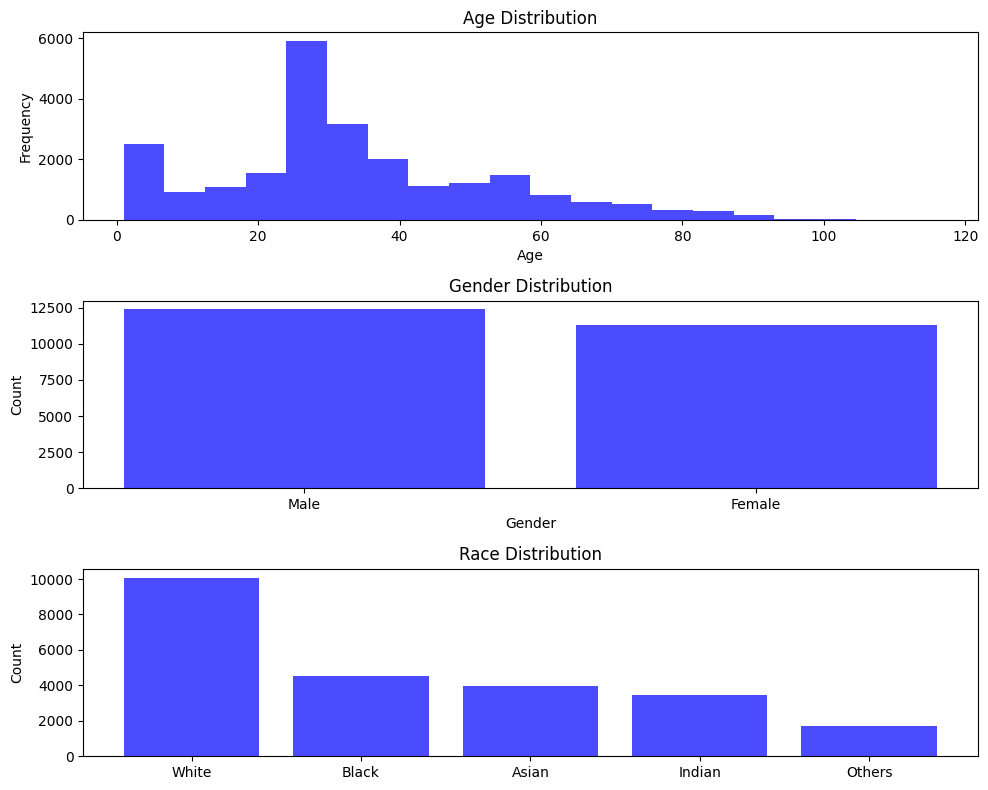

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(10, 8))

# Plot for Age
axs[0].hist(df['age'].astype(int), bins=20, alpha=0.7, color='blue')
axs[0].set(xlabel='Age', ylabel='Frequency', title='Age Distribution')

# Plot for Gender
gender_counts = df['gender'].value_counts()
axs[1].bar(gender_counts.index.map({0: 'Male', 1: 'Female'}),
           gender_counts.values, color=['blue', 'blue'], alpha=0.7)
axs[1].set(xlabel='Gender', ylabel='Count',
           title='Gender Distribution', xticks=['Male', 'Female'])

# Plot for Race
race_counts = df['race'].value_counts()
axs[2].bar(race_labels, race_counts.values, color='blue', alpha=0.7)
axs[2].set(title='Race Distribution', ylabel='Count')

plt.tight_layout()
plt.show()

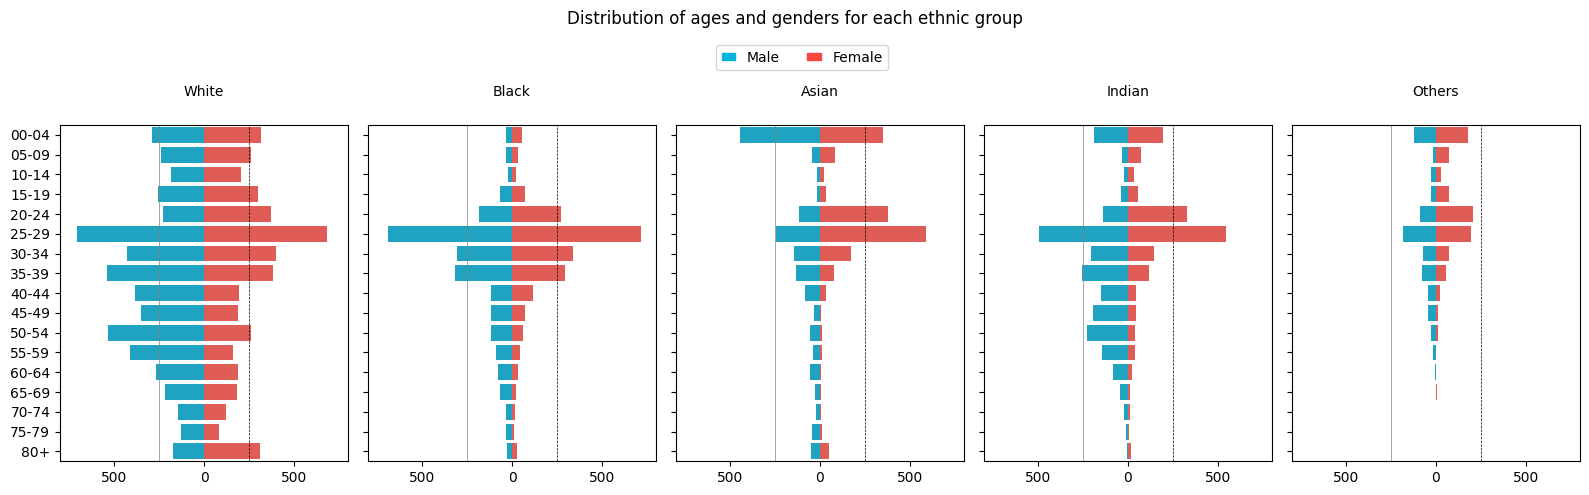

In [ ]:
age_gender_plot(df, race_labels)

From the above distributions of populations for different ethnicities we can see:
* the mojority of pictures coming from white population
* a strong imbalance between races
* different age distributions
* lacking ages groups in others
* almost balanced genders
* majority of black population covered with the age group 25-29 only
* more indian males than females

To deal with classes imbalance we will:

1) Undersample each of groups to 250 which seems to be reasonable looking at the graphs. This way we will ensure better distribution of samples but also we will loose data from: majority of white population, black population between 25-40 years, asian children up to 4 and indians between 25-29 years old. The split of data will be made based on ethnicity and belonging to the certain age group.

2) The second approach will be to augment the training data for each group and gender that doesn't have 250 samples so we will end up with around 42k samples. Still we will lack some data for others.

## Undersampling

To undersample the data we will groupby gender, race and age_group and choose random paths up to 250 samples.

In [ ]:
# Maximum number of paths to keep
paths_to_keep = 250
random_kept_df = df.groupby(['race', 'gender', 'age_group']).apply(lambda x: x.sample(n=min(paths_to_keep, len(x)))).reset_index(drop=True)

# Sanity check
group_count = random_kept_df.groupby(['race', 'gender', 'age_group'])['path'].count().to_frame().reset_index()
groups_to_reduce = group_count.loc[group_count['path'] > 250]
assert groups_to_reduce.size == 0

df = random_kept_df
df.shape

(18448, 5)

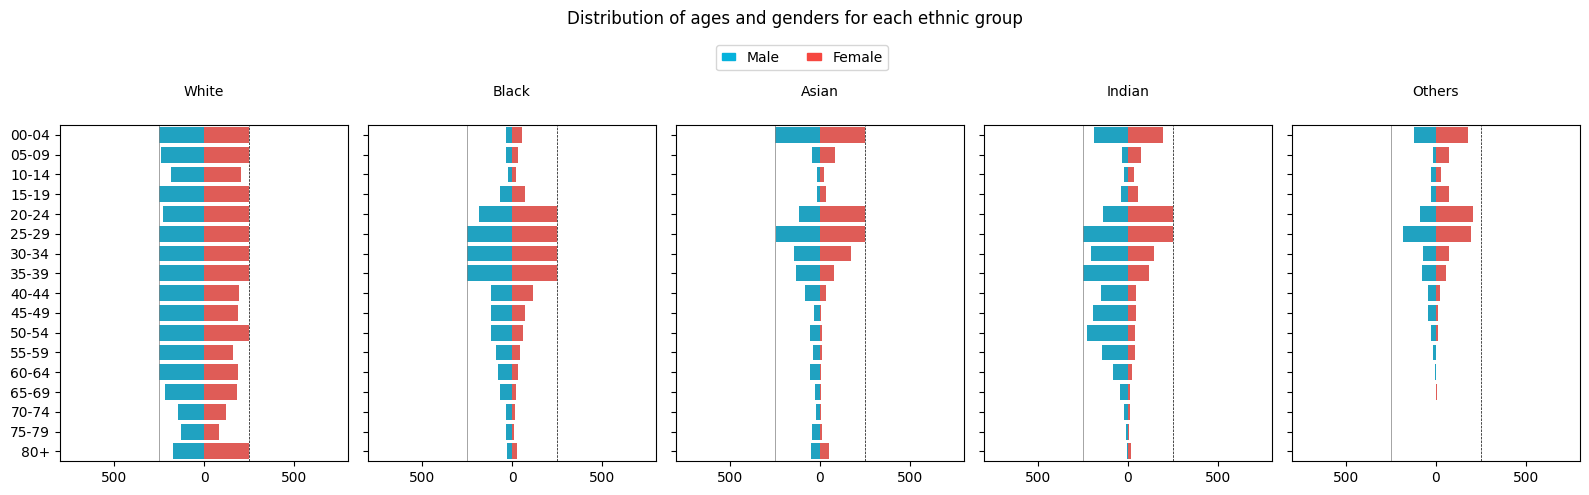

In [ ]:
age_gender_plot(df, race_labels)

## Splitting data

To split the data as uniformly as possible we will use a function for multilabel split for subgroups within the same race, gender and age_group.

In [ ]:
target_list = ['gender', 'race', 'age']
X = df[['path', 'age_group']]
y = df[target_list]
X_train, X_temp, y_train, y_temp = multilabel_train_test_split(
    X, y, test_size=0.2, stratify=y
)
X_val, X_test, y_val, y_test = multilabel_train_test_split(
    X_temp, y_temp, stratify=y_temp, test_size=0.5
)

In [ ]:
df_train = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
df_valid = pd.concat([X_val, y_val], axis=1).reset_index(drop=True)
df_test = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

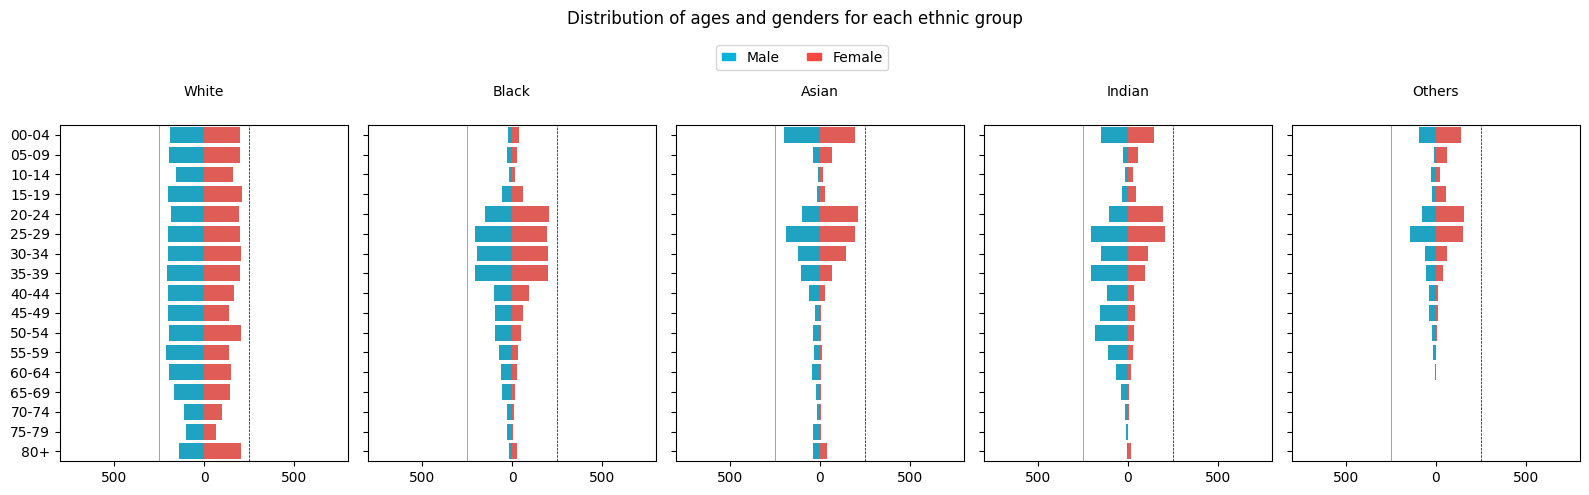

In [ ]:
age_gender_plot(df_train, race_labels)

In [ ]:
# # Storing split
# df_train.to_csv(URL + "train.csv")
# df_valid.to_csv(URL + "valid.csv")
# df_test.to_csv(URL + "test.csv")

In [ ]:
df_train = pd.read_csv(URL + "train.csv", index_col=0)
df_valid = pd.read_csv(URL + "valid.csv", index_col=0)
df_test = pd.read_csv(URL + "test.csv", index_col=0)

## Creating dummy models

To establish baseline performance we will create random outputs based od distribution probability and calculate metrices of importance:
* mse for age regression task
* accuracy for gender classification

In [ ]:
dummy_df = pd.DataFrame(df_train['age'].apply(lambda x: log(x)/4.75))
dummy_df['gender'] = df_train['gender']
num_samples = dummy_df.shape[0]
for met, col in zip(['MSE', 'Accuracy'], ['age', 'gender']):
    prob = dummy_df[col].value_counts(normalize=True).sort_index()
    random = np.random.choice(prob.index, size=num_samples, p=prob.values)
    dummy_df["pred"] = random
    print(f"{met} of {col} predictions: {mean_squared_error(dummy_df['pred'], dummy_df[col]):.3f}")

MSE of age predictions: 0.098
Accuracy of gender predictions: 0.497


## Preparing dataset and dataloaders

In [ ]:
tfms = transforms.Compose([transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])])
torch.manual_seed(123)
class FacesDataset(Dataset):
    def __init__(self, df: pd.DataFrame, url: str = URL + 'UTKFace/',
                 tfms: Any = tfms):
        """
        Custom dataset class for loading images and labels from a DataFrame.
        Args:
            df (pd.DataFrame): DataFrame containing information about
                images, gender, and age.
            url (str): Base URL for image paths.
            tfms (Any): Transformations to be applied to the images.
        """
        self.paths = [f"{url}{path}" for path in df['path'].tolist()]
        self.tfms = tfms
        self.df = df

    def __len__(self) -> int:
        """
        Get the length of the dataset.
        Returns:
            int: Number of samples in the dataset.
        """
        return len(self.paths)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor,
                                             Tuple[torch.Tensor, torch.Tensor, str]]:
        """
        Get a sample from the dataset.
        Args:
            idx (int): Index of the sample.
        Returns:
            Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor, str]]: Tuple containing the image tensor,
            age and gender tensors, and the image path.
        """
        img = Image.open(self.paths[idx])
        img = self.tfms(img)
        path = self.paths[idx]
        gender = torch.tensor(int(self.df.loc[idx, 'gender']), dtype=torch.int64)
        age = torch.tensor(pd.to_numeric(self.df.loc[idx, 'age'], errors='coerce'), dtype=torch.float32)
        return img, (torch.log(age) / 4.75, gender, path)


train_ds = FacesDataset(df_train)
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4)

valid_ds = FacesDataset(df_valid)
valid_dl = DataLoader(valid_ds, batch_size=128, shuffle=False, num_workers=4)

test_ds = FacesDataset(df_test)
test_dl = DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=4)

data = ImageDataLoaders(train_dl, valid_dl, device=torch.device('cuda'))

## Establishing a baseline losses for age and gender predictions in single task models

In [ ]:
class SingleTaskHead(nn.Module):
    def __init__(self) -> None:
        """
        SingleTaskHead class initializes a linear layer for a single task.
        Attributes:
            fc (nn.Linear): Linear layer.
        """
        super(SingleTaskHead, self).__init__()
        self.fc = nn.Linear(512, 1, bias=False)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the linear layer.
        Args:
            inputs (torch.Tensor): Input tensor.
        Returns:
            torch.Tensor: Output tensor.
        """
        return self.fc(inputs)

class SingleTaskModel(nn.Module):
    def __init__(self) -> None:
        """
        SingleTaskModel class initializes a ResNet-based model for a single task.
        Attributes:
            encoder (nn.Sequential): Encoder layers.
            dropout (nn.Dropout): Dropout layer.
            fc (SingleTaskHead): Single task head.
        """
        super(SingleTaskModel, self).__init__()
        weights = ResNet34_Weights.DEFAULT
        layers = list(resnet34(weights).children())[:-1]
        self.encoder = nn.Sequential(*layers)
        self.dropout = nn.Dropout(p=0.5)
        self.fc = SingleTaskHead()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the model.
        Args:
            x (torch.Tensor): Input tensor.
        Returns:
            torch.Tensor: Output tensor.
        """
        x = self.encoder(x).flatten(1)
        x = self.dropout(x)
        out = self.fc(x)
        return out

class AgeLoss(nn.Module):
    def __init__(self) -> None:
        """
        AgeLoss class initializes a Mean Squared Error (MSE) loss
        for age regression.
        """
        super(AgeLoss, self).__init__()

    def forward(self, preds: torch.Tensor,
                targets: Tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        """
        Calculate the age regression loss.
        Args:
            preds (torch.Tensor): Predicted age tensor.
            targets (Tuple[torch.Tensor, torch.Tensor]):
                Tuple containing the target age tensor and unused gender tensor.
        Returns:
            torch.Tensor: Age regression loss.
        """
        reg_loss = nn.MSELoss()(preds.squeeze(-1), targets[0].float())
        return reg_loss

class GenderLoss(nn.Module):
    def __init__(self) -> None:
        """
        GenderLoss class initializes a Binary Cross Entropy (BCE)
        loss with logits for gender classification.
        """
        super(GenderLoss, self).__init__()

    def forward(self, preds: torch.Tensor,
                targets: Tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        """
        Calculate the gender classification loss.
        Args:
            preds (torch.Tensor): Predicted gender logits tensor.
            targets (Tuple[torch.Tensor, torch.Tensor]):
                 Tuple containing the target gender tensor and unused age tensor.
       Returns:
            torch.Tensor: Gender classification loss.
        """
        clf_loss = nn.BCEWithLogitsLoss()(preds.squeeze(-1), targets[1].float())
        return clf_loss


### Age regression single task

In [ ]:
def train_single(model: nn.Module, loss_func: Callable) -> Tuple[Learner, nn.Module]:
    """
    Trains and fine-tunes a single-task model using the fastai library.
    Args:
        model (nn.Module): The neural network model.
        loss_func (Callable): The loss function for training.
    Returns:
        Tuple containing the trained Learner and the modified model.
    """
    opt_func = partial(OptimWrapper, opt=torch.optim.AdamW)
    learn = Learner(data, model, loss_func=loss_func, opt_func=opt_func, splitter=split_layers)
    model.encoder.requires_grad_(False)
    learn.fit_one_cycle(1, 1e-3)
    model.encoder[6:].requires_grad_(True)
    learn.fit_one_cycle(7, lr_max=slice(1e-6, 1e-3))
    return learn, model

In [ ]:
torch.manual_seed(123)
age_model = SingleTaskModel()
loss_func = AgeLoss()
learn, model = train_single(age_model, loss_func)

For regression task of age estimation the baseline of our MSE will be 0.0075.

### Gender classification single task

In [ ]:
torch.manual_seed(123)
gender_model = SingleTaskModel()
loss_func = GenderLoss()
learn, model = train_single(age_model, loss_func)

We see that gender classification model is prone to overfitting. As the hyperparameters won't be finetuned lets take our baseline as 0.5 of BCEWithLogitsLoss.

## MultiTask model with splitted training

After experimenting with different layers splits, learning rates using suggestions from fastai lr_find() for Learner object models performed best with the following procedures.

* splitting ResNet34 backbone into 3 parts: [:6], [6:7], [7:]
* training regression task for one epoch with only last linear layer unfrozen
* unfreezing [6:] from backbone and training for another epoch with MSE loss function only
* training only linear layer of gender classifier for one epoch
* unfreezing layers from backbone [6:] and training with common  loss function for 7 epochs

In [ ]:
class MultiTaskHead(nn.Module):
    def __init__(self) -> None:
        """
        MultiTaskHead class initializes two linear layers for multi-task learning.
        Attributes:
            reg (nn.Linear): Linear layer for regression task.
            clf (nn.Linear): Linear layer for classification task.
        """
        super(MultiTaskHead, self).__init__()
        self.reg = nn.Linear(512, 1, bias=False)
        self.clf = nn.Linear(512, 1, bias=False)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass through the multi-task head.
        Args:
            x (torch.Tensor): Input tensor.
        Returns:
            Tuple[torch.Tensor, torch.Tensor]:
                Output tensors for regression and classification tasks.
        """
        return self.reg(x), self.clf(x)

class MultiTaskModel(nn.Module):
    def __init__(self) -> None:
        """
        MultiTaskModel class initializes a ResNet-based model for multi-task learning.
        Attributes:
            encoder (nn.Sequential): Encoder layers.
            dropout (nn.Dropout): Dropout layer.
            fc (MultiTaskHead): Multi-task head.
        """
        super(MultiTaskModel, self).__init__()
        weights = ResNet34_Weights.DEFAULT
        layers = list(resnet34(weights).children())[:-1]
        self.encoder = nn.Sequential(*layers)
        self.dropout = nn.Dropout(p=0.5)
        self.fc = MultiTaskHead()

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass through the multi-task model.
        Args:
            x (torch.Tensor): Input tensor.
        Returns:
            Tuple[torch.Tensor, torch.Tensor]:
                Output tensors for regression and classification tasks.
        """
        x = self.encoder(x).flatten(1)
        x = self.dropout(x)
        age, gender = self.fc(x)
        return age, gender

class MultiTaskLossUpdated(nn.Module):
    def __init__(self, task: str) -> None:
        """
        MultiTaskLossUpdated class initializes a multi-task loss function.
        Args:
            task (str): Task type, either 'reg' for regression,
                'clf' for classification, or 'both' for both.
        Attributes:
            task (str): Task type.
        """
        super(MultiTaskLossUpdated, self).__init__()
        self.task = task

    def forward(self, preds: Tuple[torch.Tensor, torch.Tensor],
                targets: Tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        """
        Calculate the multi-task loss.
        Args:
            preds (Tuple[torch.Tensor, torch.Tensor]):
                Predicted tensors for regression and classification tasks.
            targets (Tuple[torch.Tensor, torch.Tensor]):
                Target tensors for regression and classification tasks.
        Returns:
            torch.Tensor: Loss.
        """
        reg_loss = nn.MSELoss()(preds[0].squeeze(-1), targets[0].float())
        clf_loss = nn.BCEWithLogitsLoss()(preds[1].squeeze(-1), targets[1].float())

        if self.task == 'reg':
            return reg_loss

        elif self.task == 'clf':
            return clf_loss

        else:
            return 300 * reg_loss + clf_loss

def loss_age(preds: Tuple[torch.Tensor, torch.Tensor],
             targets: Tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
    """
    Calculate the age regression loss.
    Args:
        preds (Tuple[torch.Tensor, torch.Tensor]):
            Predicted tensors for regression and classification tasks.
        targets (Tuple[torch.Tensor, torch.Tensor]):
            Target tensors for regression and classification tasks.
    Returns:
        torch.Tensor: Age regression loss.
    """
    return nn.MSELoss()(preds[0].squeeze(-1).cpu(), targets[0].float().cpu())

def loss_gender(preds: Tuple[torch.Tensor, torch.Tensor],
                targets: Tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
    """
    Calculate the gender classification loss.
    Args:
        preds (Tuple[torch.Tensor, torch.Tensor]):
            Predicted tensors for regression and classification tasks.
        targets (Tuple[torch.Tensor, torch.Tensor]):
            Target tensors for regression and classification tasks.
    Returns:
        torch.Tensor: Gender classification loss.
    """
    return nn.BCEWithLogitsLoss()(preds[1].squeeze(-1).cpu(),
                                  targets[1].float().cpu())

def acc_gender(preds: Tuple[torch.Tensor, torch.Tensor],
               targets: Tuple[torch.Tensor, torch.Tensor]) -> float:
    """
    Calculate the accuracy for gender classification.
    Args:
        preds (Tuple[torch.Tensor, torch.Tensor]):
            Predicted tensors for regression and classification tasks.
        targets (Tuple[torch.Tensor, torch.Tensor]):
            Target tensors for regression and classification tasks.
    Returns:
        float: Accuracy for gender classification.
    """
    y_true = targets[1].int().cpu()
    y_hat = (torch.sigmoid(preds[1].squeeze(-1).cpu()) > 0.5).float()
    return accuracy_score(y_true, y_hat)


metrics = [loss_age, loss_gender, acc_gender]
opt_func = partial(OptimWrapper, opt=torch.optim.AdamW)

In [ ]:
def train_multi() -> Tuple[Learner, MultiTaskModel]:
    """
    Train a multi-task model using the fastai library with three training stages:
    1. Training for regression only.
    2. Training for classification only.
    3. Training for both regression and classification.

    Returns:
        Tuple containing the trained Learner and the modified multi-task model.
    """

    torch.manual_seed(123)
    model = MultiTaskModel()

    # Training regression only
    loss_func = MultiTaskLossUpdated('reg')
    learn = Learner(data, model, loss_func=loss_func,
                    opt_func=opt_func, splitter=split_layers, metrics=metrics)
    model.encoder.requires_grad_(False)
    model.fc.clf.requires_grad_(False)
    model.encoder[6:].requires_grad_(True)
    learn.fit_one_cycle(1, 1e-3)
    learn.fit_one_cycle(1, lr_max=slice(1e-6, 1e-3))

    # Training classification
    loss_func = MultiTaskLossUpdated('clf')
    learn = Learner(data, model, loss_func=loss_func,
                    opt_func=opt_func, splitter=split_layers, metrics=metrics)
    model.fc.reg.requires_grad_(False)
    model.encoder.requires_grad_(False)
    model.fc.clf.requires_grad_(True)
    learn.fit_one_cycle(2, 1e-3)

    # Both
    loss_func = MultiTaskLossUpdated('both')
    learn = Learner(data, model, loss_func=loss_func,
                    opt_func=opt_func, splitter=split_layers, metrics=metrics)
    model.fc.reg.requires_grad_(True)
    model.encoder[6:].requires_grad_(True)
    model.fc.clf.requires_grad_(True)
    learn.fit_one_cycle(7, lr_max=slice(1e-6, 1e-3))
    return learn, model

In [ ]:
# learn, model = train_multi()

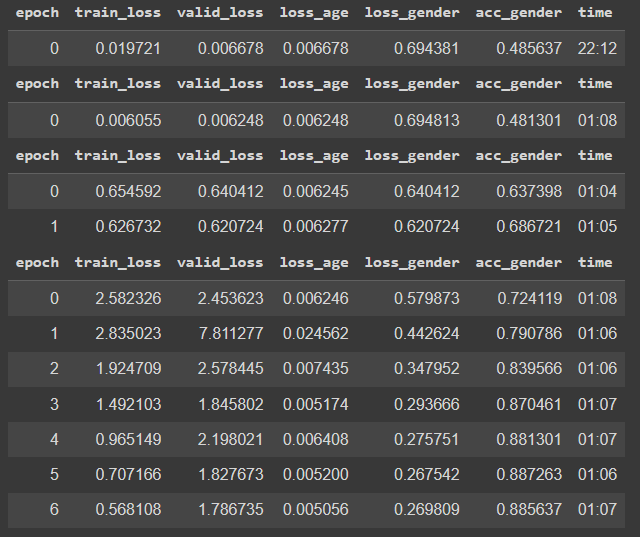

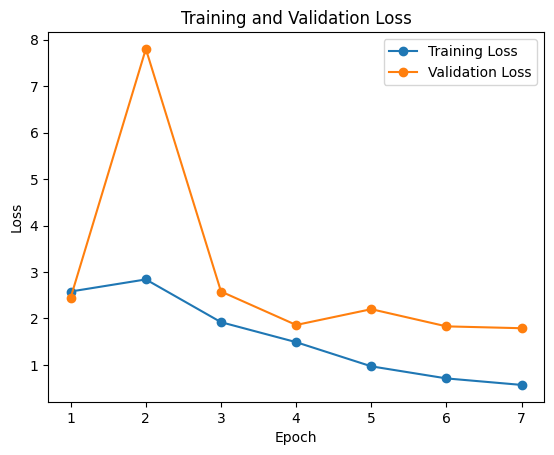

In [ ]:
# learn.recorder.plot_loss()

In [ ]:
#torch.save(model.state_dict(), URL+'splitted-age0.005-gender0.89.pth')

## ResNet34 with data augmentation

For this task we will augment data from training set to contain 250 images for each gender, ethincity, age_group.

In [ ]:
grouped = df_train.groupby(['race', 'gender', 'age_group'])
paths_by_group = []
import random
for name, group in grouped:
    paths = group['path'].tolist()
    paths_by_group.append(paths)
# Augmentation
for group in paths_by_group:
    augment_images(group)

In [ ]:
filenames = [file for _, _, file in os.walk("/content/aug_data/")]
files = filenames[0]

aug_df = pd.DataFrame()
aug_df['path'] = files
aug_df["age"] = aug_df["path"].apply(lambda x: x.split("_")[0]).astype(int)
aug_df["gender"] = aug_df["path"].apply(lambda x: x.split("_")[1]).astype(int)
aug_df["race"] = aug_df["path"].apply(lambda x: x.split("_")[2]).astype(int)

age_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50,
            55, 60, 65, 70, 75, 80, float('inf')]
age_labels = ['00-04', '05-09', '10-14', '15-19', '20-24',
              '25-29', '30-34', '35-39','40-44', '45-49',
              '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80+']
aug_df['age_group'] = pd.cut(aug_df['age'].astype(int),
                             bins=age_bins, labels=age_labels, right=False)

Sanity check of distribution.

In [ ]:
age_gender_plot(aug_df, race_labels)

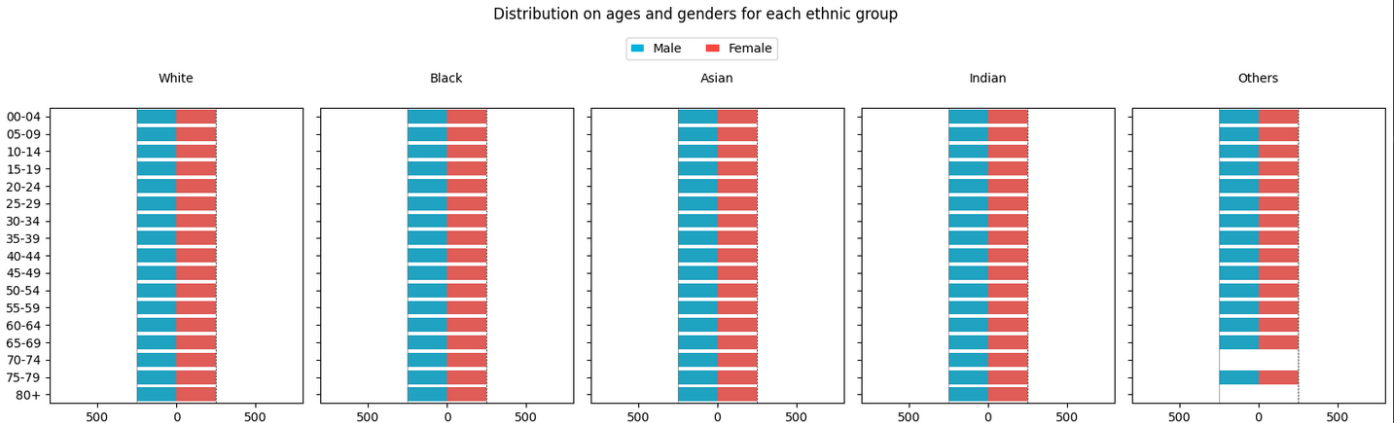

In [ ]:
train_ds = FacesDataset(aug_df, '/content/aug_data/')
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4)
data = ImageDataLoaders(train_dl, valid_dl, device=torch.device('cuda'))

In [ ]:
# learn, model = train_multi()

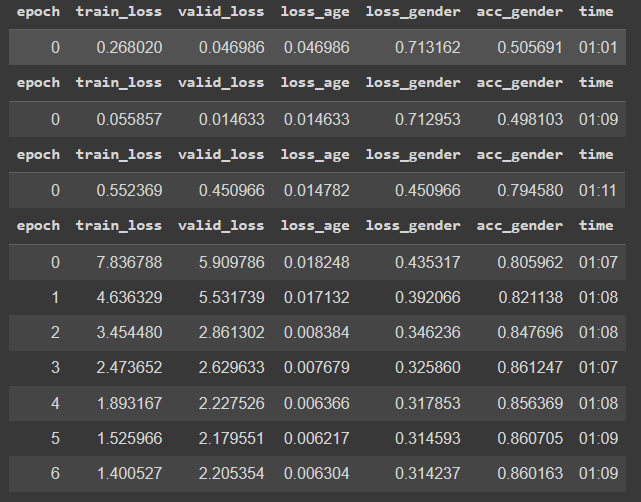

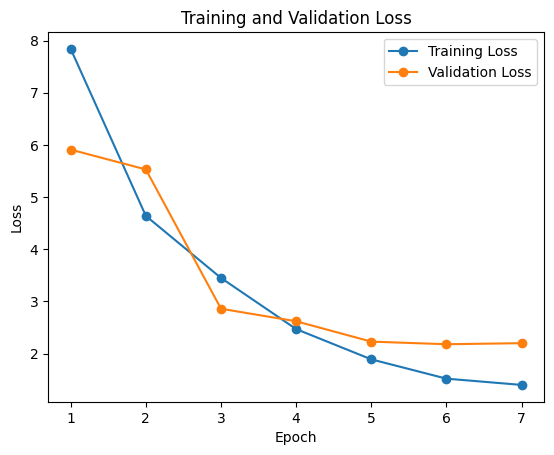

In [ ]:
# learn.recorder.plot_loss()

In [ ]:
# torch.save(model.state_dict(), URL + "resnet34_aug.pth")

## Evaluation of model with and without data augmentation

In [ ]:
# Model without augmentation
model = MultiTaskModel()
state_dict = torch.load('/content/drive/MyDrive/Colab/faces/splitted-age0.005-gender0.89.pth')
model.load_state_dict(state_dict)

# Model with augmentation
aug_model = MultiTaskModel()
state_dict = torch.load('/content/drive/MyDrive/Colab/faces/resnet34_aug.pth')
aug_model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
df_pred1 = prediction_df_builder(*get_predictions(model, test_dl, device))
df_pred2 = prediction_df_builder(*get_predictions(aug_model, test_dl, device))

### Age prediction analysis

The age error in both models:


Model  Augmented Model
mean  10.15            10.66
std   15.93            15.48
min    0.00             0.00
max   60.00            65.00

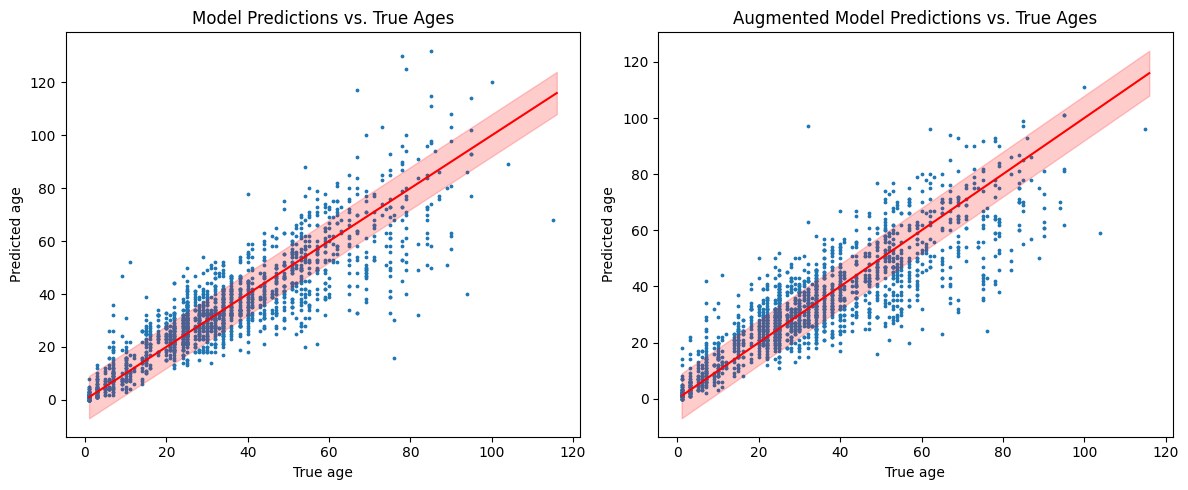

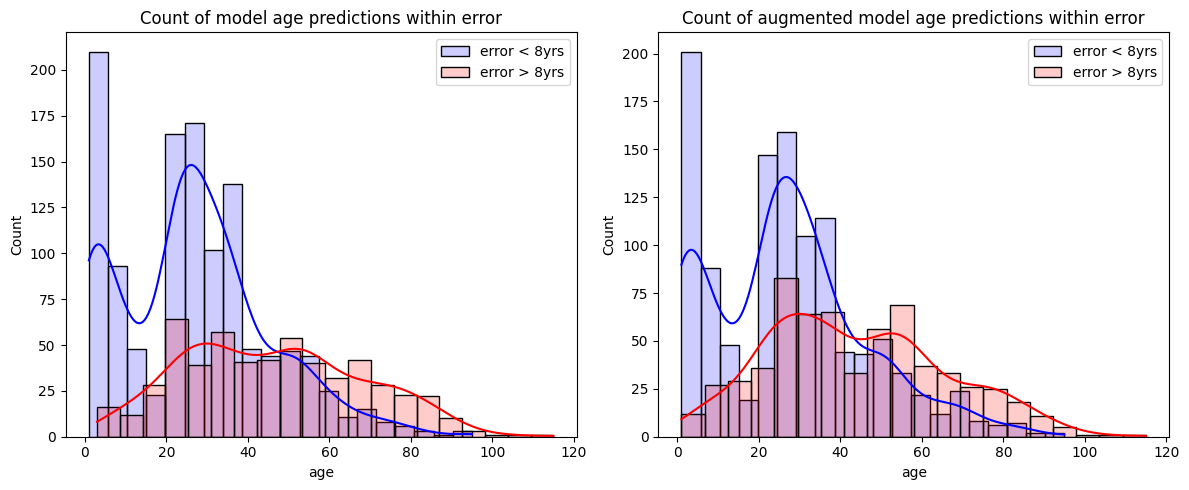

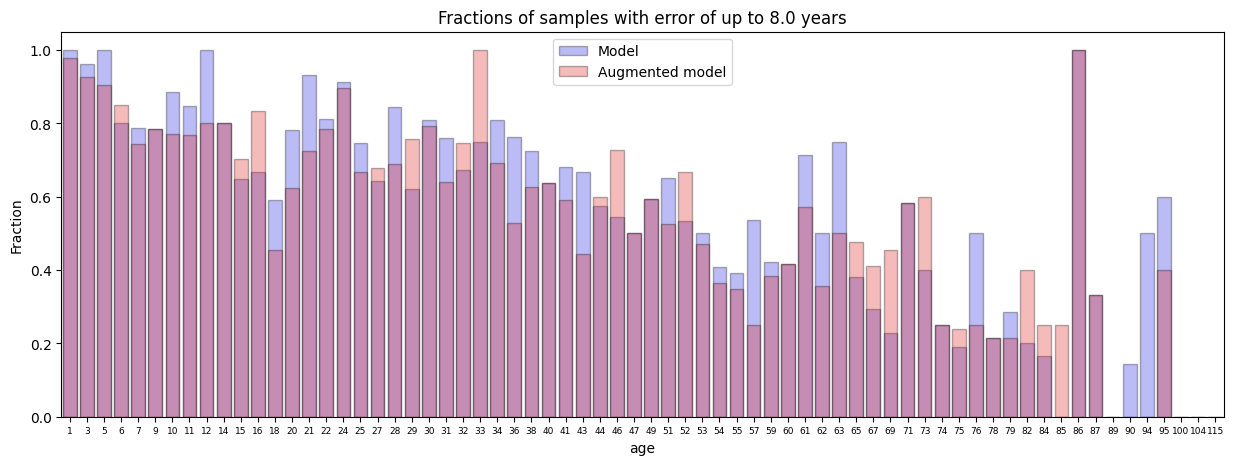

In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format)
statistics_model = df_pred1['mse'].describe()[['mean', 'std', 'min', 'max']]
statistics_aug_model = df_pred2['mse'].describe()[['mean', 'std', 'min', 'max']]
statistics_df = pd.DataFrame({
    'Model': statistics_model,
    'Augmented Model': statistics_aug_model
}).apply(np.sqrt)
print('The age error in both models:')
display(statistics_df)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_age_prediction(ax1, df_pred1, 'Model Predictions vs. True Ages')
plot_age_prediction(ax2, df_pred2, 'Augmented Model Predictions vs. True Ages')
plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_pred_dist(ax1, df_pred1, 'Count of model age predictions within error')
plot_pred_dist(ax2, df_pred2, 'Count of augmented model age predictions within error')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
plot_correct_fractions(df_pred1, df_pred2)
plt.show()

* On average the model without augmentation was closer to real age of person on the picture by half a year than model with augmentation.
* The predictions of model without augmentation were slightly more spread out and the maximum error was lower by 5 years.
* The augmented model was leaning toward predicting lower ages than the true label.
* The augmented model had more over 8 years error especially in older people.
* The model without augmentation gave better age estimations for majority of ages for up to 60 but over that the augmented model worked better, which means the augmentation added value to ages which were in minority.
* Intererstingly calculating the average of predicted ages from both models I got the RMSE of 9.5 years on test set.


 *************** Model without augmentation worst age predictions *************** 



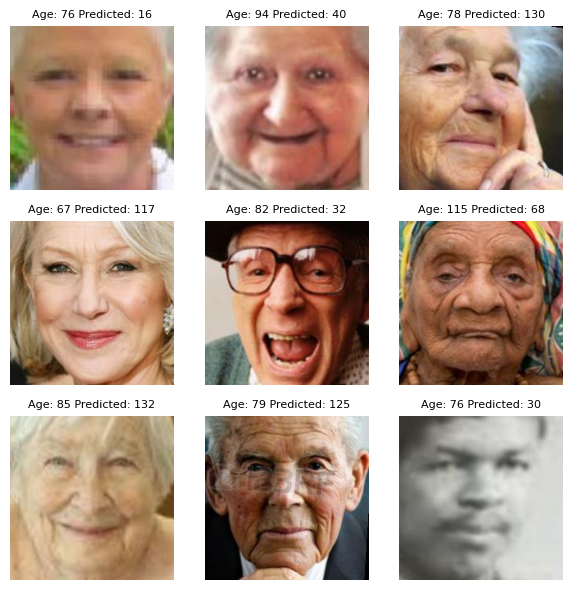


 *************** Model with augmentation worst age predictions *************** 



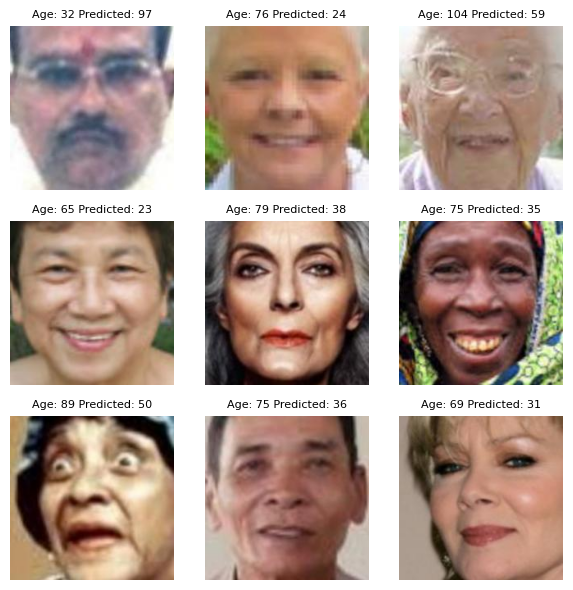

In [ ]:
print('\n', '*'*15, 'Model without augmentation worst age predictions', '*'*15, '\n')
plot_image_pred(df_pred1, 'mse', False)
plt.show()
print('\n', '*'*15, 'Model with augmentation worst age predictions', '*'*15, '\n')
plot_image_pred(df_pred2, 'mse', False)
plt.show()

One of the pictures is scoring highly wrong for both models. The others when we look with human eye are bit unreasonable.

### Gender prediction analysis

******************** Model report on gender classification ******************** 

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       972
           1       0.88      0.86      0.87       872

    accuracy                           0.88      1844
   macro avg       0.88      0.88      0.88      1844
weighted avg       0.88      0.88      0.88      1844



<Figure size 800x600 with 0 Axes>

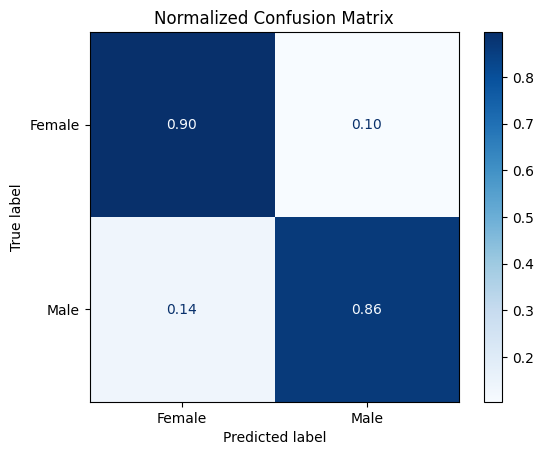

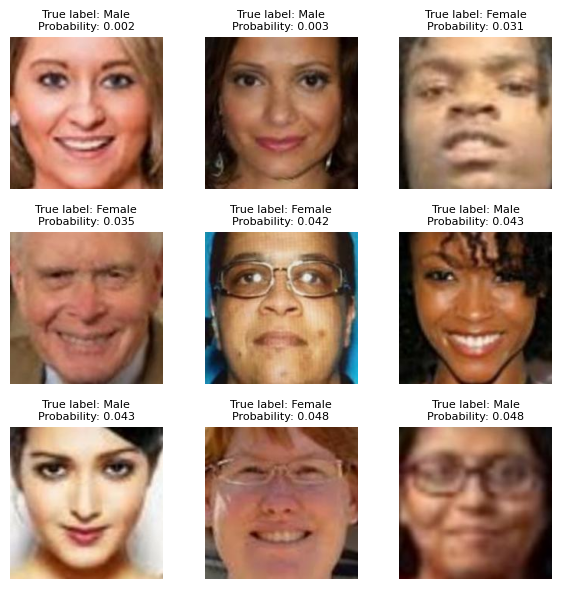

******************** Augmented model report on gender classification ******************** 

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       972
           1       0.88      0.80      0.84       872

    accuracy                           0.85      1844
   macro avg       0.85      0.85      0.85      1844
weighted avg       0.85      0.85      0.85      1844



<Figure size 800x600 with 0 Axes>

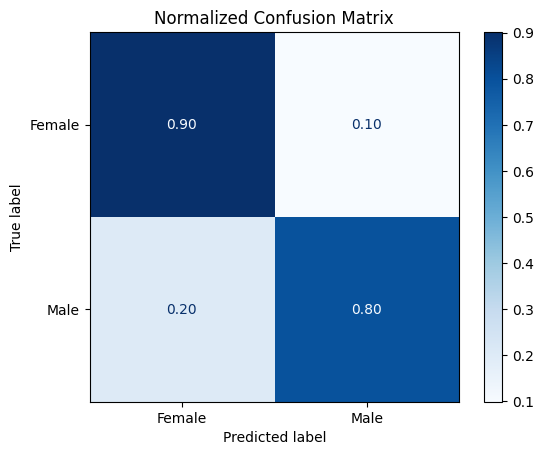

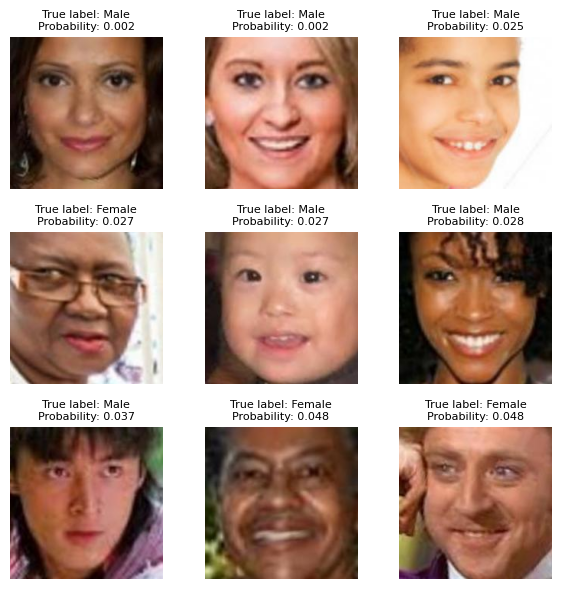

In [ ]:
clf_reporting(df_pred1['gender'], df_pred1['pred_gender'],
              'Model report on gender classification')
plot_image_pred(df_pred1, 'acc', False)

clf_reporting(df_pred2['gender'], df_pred2['pred_gender'],
              'Augmented model report on gender classification')
plot_image_pred(df_pred2, 'acc', False)

* A lot of pictures are mislabled. The model without augmentation picked up on this fenomena without any problem. The model with augmentation focuses on different set of facial features.
* Not augmented model performed better on predicting gender.
* For both models it was much easier to get the right prediction of femal than of male. The models got some mistakes predicting females while the true label was male.

### Estimating average performance for model without augmentation

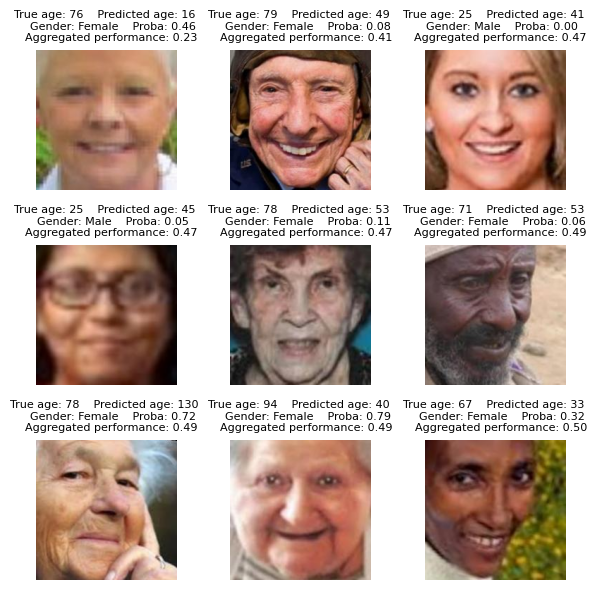

In [ ]:
# The lower the aggregated performance the better
df_pred1['aggregate_performance'] = 0.5*df_pred1['acc'] + 0.5*df_pred1['mse']/df_pred1['mse'].max()
worst_per = df_pred1.sort_values(by='aggregate_performance', ascending=False).reset_index(drop=True)

fig, axes = plt.subplots(3, 3, figsize=(6, 6))
axes = axes.flatten()

# Loop through images and display them in subplots
for i, ax in enumerate(axes):
    image = Image.open(worst_per.at[i, 'path'])
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f"True age: {worst_per.at[i, 'age']}\
    Predicted age: {worst_per.at[i, 'pred_age']} \n\
    Gender: {np.where(worst_per.at[i, 'gender'], 'Female', 'Male')}\
    Proba: {worst_per.at[i, 'proba']:.2f}\n\
    Aggregated performance: {1 - worst_per.at[i, 'aggregate_performance']:.2f} ", fontsize=8)

plt.tight_layout()
plt.show()

We still see some of the pictures that have already appeared earlier. All of them seem to be to some extend mislabeled or the quality of the pictures is weak.

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

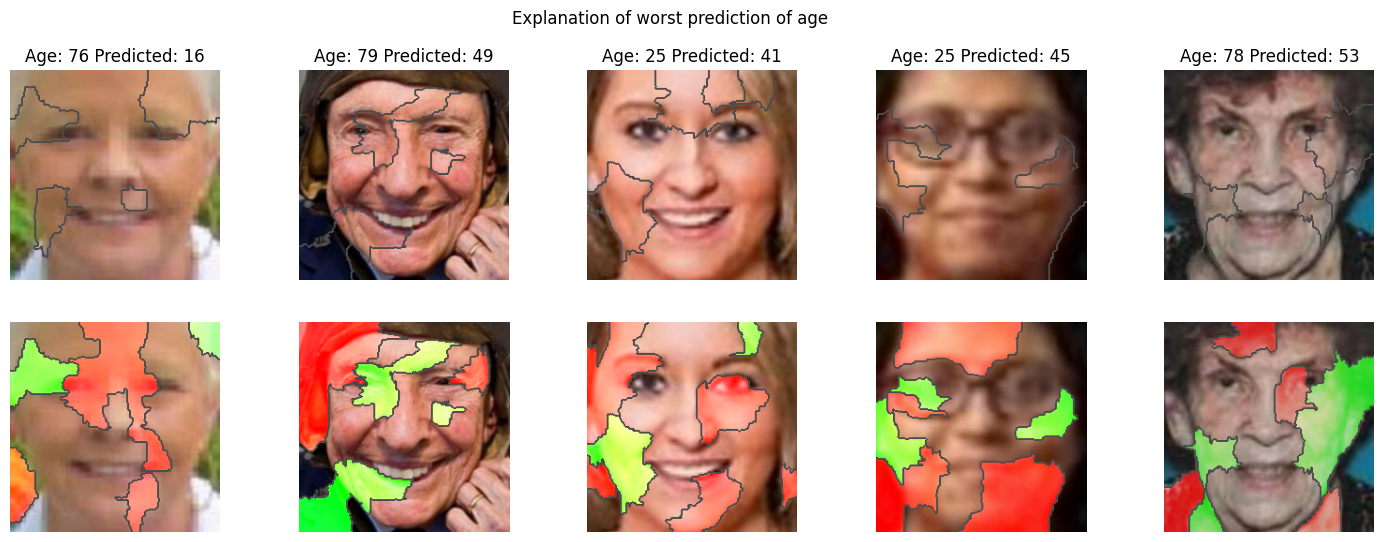

In [ ]:
plot_explanations(worst_per, 'Explanation of worst prediction of age', 'reg')

* First picture is wrongly labeled.
* Looking closely we can only assume that for the model takes smoothness of color as predictor, laughing wrinkles, the shape of teeth, texture of hair. These are still only assumptions.

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

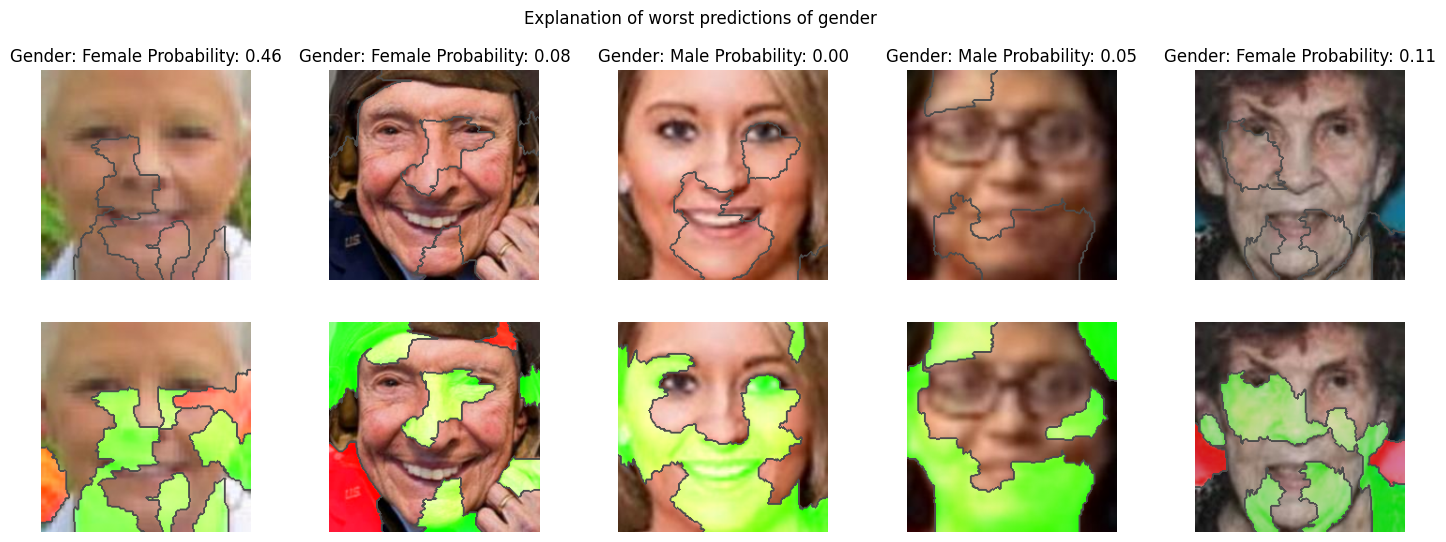

In [ ]:
plot_explanations(worst_per, 'Explanation of worst predictions of gender', 'clf')

* Predicting gender from picture should be much easier and certainly it is. There are some facial characteristics which dominate female faces and male faces.
* In here we see that the model was actually right and picked up on gender features correctly.

## Analysing bias



Before we proceed with bias in the model which was already visible in age analysis let's see how the metrics behave for age, gender and ethincity groups.

For this task we will buid a dataframe with specific columns and agregate them to have a better overview.

mse                        acc               
        min     max   mean    std  min  max mean  std
gender                                               
0      0.00 2500.00  97.33 210.02 0.00 1.00 0.15 0.22
1      0.00 3600.00 109.47 294.88 0.00 0.97 0.20 0.24


 Summary of predictions grouped by age group 



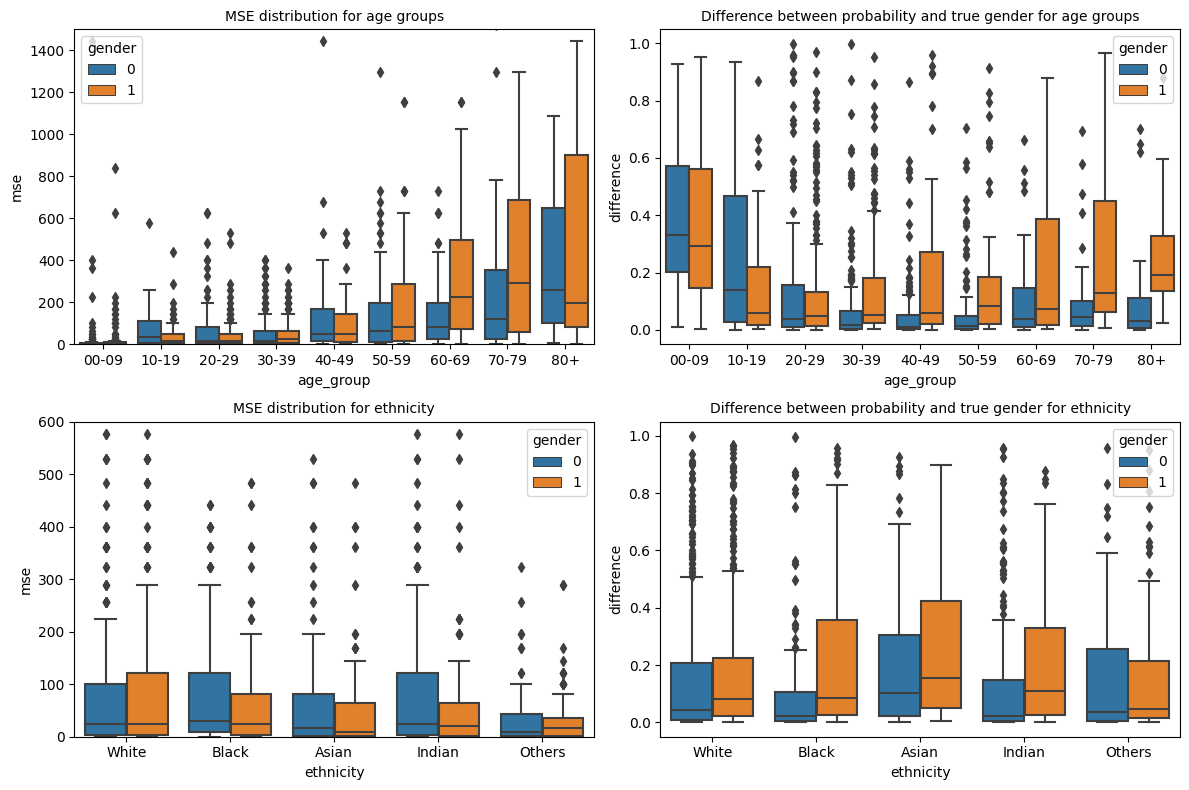

In [ ]:
age_bins = [0, 10, 20,  30, 40, 50, 60, 70, 80, float('inf')]
age_labels = ['00-09', '10-19', '20-29', '30-39',
              '40-49',  '50-59', '60-69',  '70-79', '80+']
race_mapper = {i: race for i, race in enumerate(race_labels)}
aggs = ['min', 'max', 'mean', 'std']
df_pred1['age_group'] = pd.cut(df_pred1['age'].astype(int), bins=age_bins,
                               labels=age_labels, right=False)
df_pred1['ethnicity'] = df_pred1['path'].apply(lambda x: int(x[43:].split('_')[2]) if x[43:].split('_')[2].isdigit() else None)
df_pred1['ethnicity'] = df_pred1['ethnicity'].apply(lambda x: race_mapper[x])

display(df_pred1.groupby(['gender'])['mse', 'acc'].agg({'mse': aggs, 'acc': aggs}))
print(f"\n Summary of predictions grouped by age group \n")
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
sns.boxplot(data=df_pred1, x='age_group', y='mse', hue='gender', ax=ax[0, 0])
ax[0, 0].set_title('MSE distribution for age groups', fontsize=10)
ax[0, 0].set_ylim(0, 1500)
sns.boxplot(data=df_pred1, x='age_group', y='acc', hue='gender', ax=ax[0, 1])
ax[0, 1].set_title('Difference between probability and true gender for age groups', fontsize=10)
ax[0, 1].set_ylabel('difference')
sns.boxplot(data=df_pred1, x='ethnicity', y='mse', hue='gender', ax=ax[1, 0])
ax[1, 0].set_title('MSE distribution for ethnicity', fontsize=10)
ax[1, 0].set_ylim(0, 600)
sns.boxplot(data=df_pred1, x='ethnicity', y='acc', hue='gender', ax=ax[1, 1])
ax[1, 1].set_title('Difference between probability and true gender for ethnicity', fontsize=10)
ax[1, 1].set_ylabel('difference')
plt.tight_layout()
plt.show()

* It was easier for the model to estimate the age and gender of males than of females.
* The model predicts the age best for ages up to 40 but best ages 20-40. Gender is best predicted for ages 50-59 and 30-39.
* Interestingly the model predict the age of Others with squered error on average equals to 36 although the samples is the smallest.
* The age of White and Black race seems to be the harders to predict.
* The model is having problem with predicting gender of Asian people.

The bias in age predictions, whether from human judgment or machine learning models, raises critical considerations for fairness, accuracy, and ethical implications. Let's elaborate on the provided information:

Human vs. Model Performance:

* Human Error: Humans, on average, make an error of 8 years in age estimation (https://royalsocietypublishing.org/doi/10.1098/rsos.180841)
* Model Performance: The machine learning model performs less accurately, with an average error of 10-11 years. This indicates a potential need for model improvement.
Age Prediction Discrepancies:

Age Groups:

The model exhibits up to an 8-year error for individuals up to 40 years old, but the mean and standard deviation increase for older individuals. This could stem from imbalances in the data or challenges in capturing age-related features in older age groups.

Data Imbalance Issues:

Augmented Model Bias: The augmented model displays consistent biases, assigning higher ages to younger individuals and lower ages to older ones. Data imbalances may contribute to these biases, emphasizing the importance of diverse and representative datasets.

Ethnicity and Gender Sensitivity:

Facial Features: Ethnicity-related biases are observed, emphasizing the need for caution when predicting ages for White and Black individuals and gender for Asian individuals. Facial features play a significant role in these biases, calling for ethical considerations.

Ethical Considerations:

* Gender Classification Sensitivity: Classifying individuals into binary gender categories (male and female) can cause distress for users who identify differently. Ethical practices dictate sensitivity towards diverse gender identities.

Deployment Limitations:

* Limited Deployment Possibilities: The current limitations suggest that deploying such a model has constraints, primarily suitable for entertainment purposes. Considering potential distress caused by inaccurate predictions, the practical applications, especially in personalized advertising, need careful consideration.
Impact on Users:

* Distress and Consumer Trust: Inaccurate predictions, especially in sensitive attributes like age and gender, may cause distress among users. Deploying the model for personalized advertising could negatively impact consumer trust, especially if the proposed products are gender-specific.


In conclusion, addressing biases in age prediction models involves ongoing efforts to improve accuracy, mitigate imbalances in data, and prioritize ethical considerations. Understanding the limitations and potential impacts on users is crucial for responsible development and deployment of such models. Balancing technological advancements with ethical considerations is essential to ensure positive user experiences and prevent potential harm.


## Imporvements

* Correct the gender and age labels or remove them from the training set. Then retrain the model.
* Get better set of pictures.
* Use different techniques for augmentation of data.
* Trying different backbones  
* Using weights in loss functions for training
* Checking if 0.5 threshold for classification is optimal